In [ ]:
from google.colab import drive

drive.mount("/content/gdrive") 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/Bloque 2 IA/Estadistica/Entregable 2"
!ls

/content/gdrive/MyDrive/Bloque 2 IA/Estadistica/Entregable 2
'Entregable 2.ipynb'   Entregable2.ipynb   IGAE.csv   Indicadores.xlsx


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Entregable 2

## Lectura de datos

In [ ]:
df = pd.read_csv('IGAE.csv')
df

,Periodo,Valor
0,2022/08,113.320302
1,2022/07,111.268587
2,2022/06,112.797501
3,2022/05,114.442424
4,2022/04,109.529866
...,...,...
351,1993/05,63.612900
352,1993/04,61.865984
353,1993/03,63.943249
354,1993/02,61.022521


Sorteamos los valores segun el periodo, receteamos y dropeamos los index para poder reordenar de forma periodica los datos

In [ ]:
df = df.sort_values(by='Periodo')
df = df.reset_index(drop=True)

##Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable

Podemos ver segun el plot de 'Valor' que nuestra variable es no estacionaria, ya que tiene un crecimiento visible

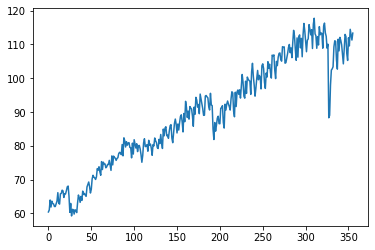

In [ ]:
df['Valor'].plot()

Calculamos la diferencia entre el logaritmo de los valores anuales del crecimiento indice de volumen fisico base, esto con el fin de estacionarizar los datos 

In [ ]:
df['lnair'] = np.log(df['Valor'])  - np.log(df['Valor']).shift(12)
df

,Periodo,Valor,lnair
0,1993/01,60.407691,NaN
1,1993/02,61.022521,NaN
2,1993/03,63.943249,NaN
3,1993/04,61.865984,NaN
4,1993/05,63.612900,NaN
...,...,...,...
351,2022/04,109.529866,0.013414
352,2022/05,114.442424,0.021001
353,2022/06,112.797501,0.014522
354,2022/07,111.268587,0.012578


Dropeamos nans

In [ ]:
df2 = df.dropna().copy()

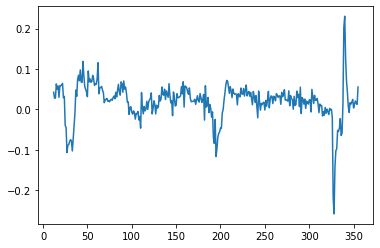

In [ ]:
df2['lnair'].plot()

Con este grafico, podemos ver cierta tendencia a estacionaridad, pero para poder comprobar esto, usaremos el Dicky-Fuller test

https://www.statology.org/dickey-fuller-test-python/

In [ ]:
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(df2['lnair'])
p_value[1]

0.003199714140110552

Podemos ver que tenemos un p-value de 0.00320, por lo que posemos usar los valores de D = 1 y d = 0 para calcular el porcentaje de cambio anual segun el mes, debido a que nuestra variable ya es estacionaria y con esto proseguimos a usar un modelo ARIMA-SARIMA

## Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones . Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.

Realizamos el grafico de autocorrelaciones (ACF) y una autocorrelacion parcial de los datos(PACF) para conocer la aucorrelacion de los datos con sus lags

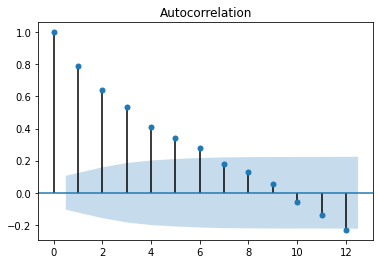

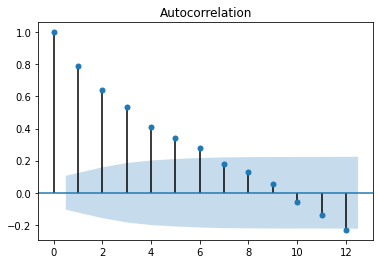

In [ ]:
plot_acf(df2['lnair'], lags = 12)

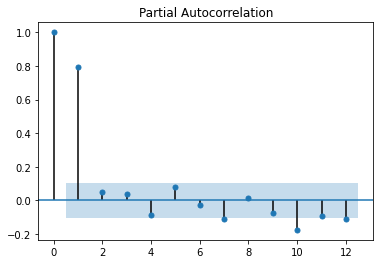

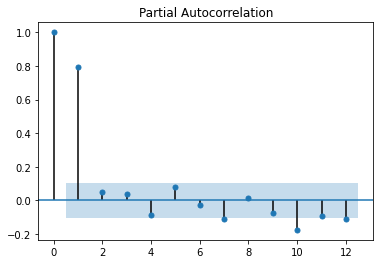

In [ ]:
plot_pacf(df2['lnair'], lags = 12)

En el grafico de autocorrelacion, podemos ver que esta va descendiendo, entre mayor el lag, y nos damos cueta que los lags anteriores a 7 se encuentran por encima del 95% de significancia.

Por otro lado, en la autocorrelacion parcial unicamente se ve una autocorrelacion explictiva en el primer lag.

Debido a esto, tomaremos un valor de p = 1 y q = 0


##Estimacion del modelo ARIMA-SARIMA

Variables para el modelo ARIMA-SARIMA

###Modelo 1

In [ ]:
#Arima(1,0,0)
p = 1
q = 0
d = 0

#SARIMA(0,0,1,12)
P = 0
Q = 0
D = 1
num_per = 12

In [ ]:
import statsmodels.api as sm

df2['y'] = np.log(df2['Valor'])
model1 = sm.tsa.statespace.SARIMAX(df2['y'], order = (p, d, q), seasonal_order = (P, D, Q, num_per), trend = 'c',  simple_differencing = True)
aux = model1.fit()
print(aux.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                             DS12.y   No. Observations:                  332
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 714.064
Date:                            Sat, 26 Nov 2022   AIC                          -1422.127
Time:                                    04:11:40   BIC                          -1410.712
Sample:                                         0   HQIC                         -1417.575
                                            - 332                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.626      0.009       0.001       0.007
ar.L1          0.7878      0.022   

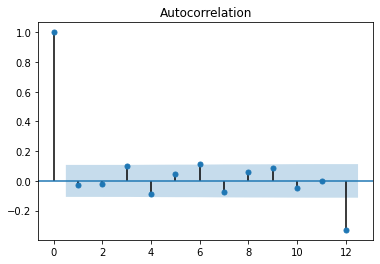

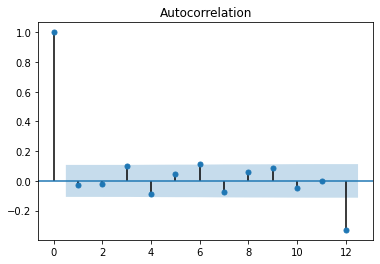

In [ ]:
plot_acf(aux.resid, lags = 12)

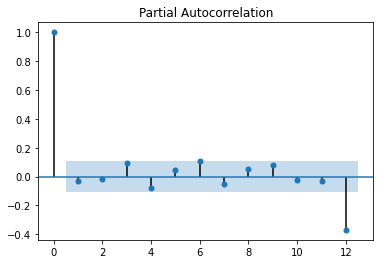

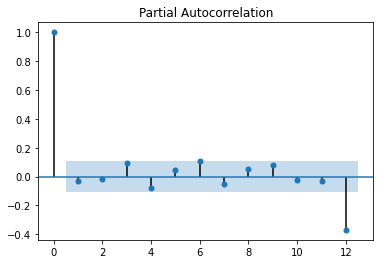

In [ ]:
plot_pacf(aux.resid, lags = 12)

Como podemos ver el las graficas, tenemos ruido en el lag 12, yendo este hacia abajo, por o que cambiaremos el parametro Q de 0 a 1 para tratar de corregir este error

###Modelo 2

In [ ]:
Q = 1

In [ ]:
modelo2 = sm.tsa.statespace.SARIMAX(df2['y'], order = (p, d, q), seasonal_order = (P, D, Q, num_per),  trend = 'c',  simple_differencing = True)
aux2 = modelo2.fit()
print(aux2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                               DS12.y   No. Observations:                  332
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 777.666
Date:                              Sat, 26 Nov 2022   AIC                          -1547.332
Time:                                      04:11:44   BIC                          -1532.111
Sample:                                           0   HQIC                         -1541.262
                                              - 332                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.000      6.158      0.000       0.002       0.003
ar.L1          0.87

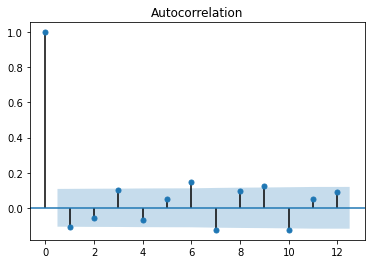

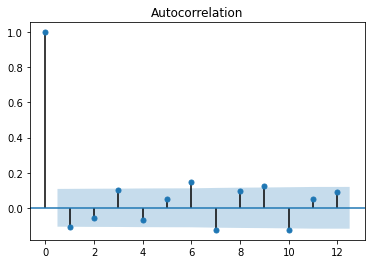

In [ ]:
plot_acf(aux2.resid, lags = 12)

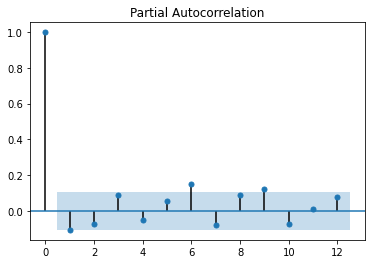

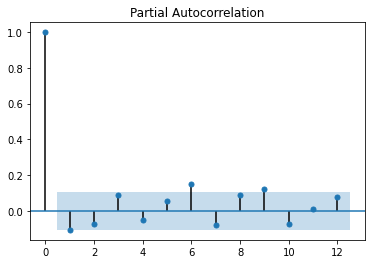

In [ ]:
plot_pacf(aux2.resid, lags = 12)

Se puede mejorar la calibración ya que en el último gráficos de AC-PACS se ve ligeramente que la autocorrelación con lag 1 es negativa y sig. Por lo que cambiamos de q=0 a q=1

###Modelo 3

In [ ]:
q = 1

In [ ]:
modelo3 = sm.tsa.statespace.SARIMAX(df2['y'], order = (p, d, q), seasonal_order = (P, D, Q, num_per),  trend = 'c',  simple_differencing = True)
aux3 = modelo3.fit()
print(aux3.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                             DS12.y   No. Observations:                  332
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 781.071
Date:                            Sat, 26 Nov 2022   AIC                          -1552.142
Time:                                    04:11:50   BIC                          -1533.116
Sample:                                         0   HQIC                         -1544.554
                                            - 332                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.000      3.363      0.001       0.001       0.003
ar.L1          0.9211      0.023   

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


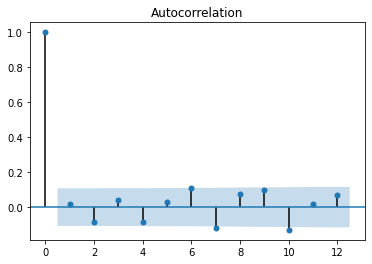

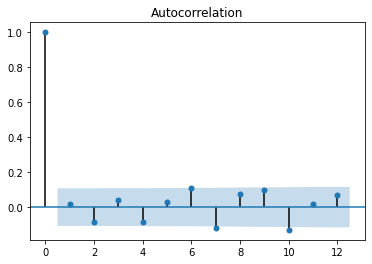

In [ ]:
plot_acf(aux3.resid, lags = 12)

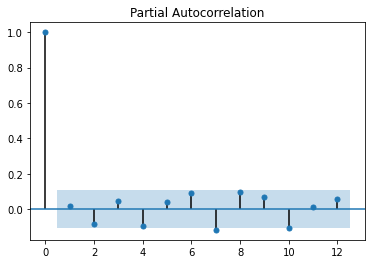

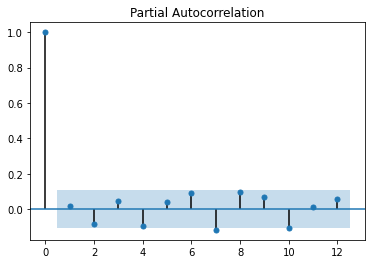

In [ ]:
plot_pacf(aux3.resid, lags = 12)

Como podemos ver en estos graficos, los lags de la variable ya se encientran todas por debajo del 95%, tanto en la cutocorrelacion parcial como en la normal, por lo que ya no generan ruido en nuestro modelo. 

En cuanto al p-value de nuestras variables, todos tienen un valor muy bajo, por lo que las variables pueden ser consideradas como relevantes. 

Gracias a esto, ya podemos generar un modelo, el cual seria:

y_(t) = 0.0016 + 0.9211 * y_(t-1) - 0.1867 * E_(t-1) - 0.8465 * E_(t-12)+- 0.0005(Desviacion estandar)






###Descripcion de las variables

Con esto, nos damos cuenta que:
* el valor de 'y' anterior tiene una significancia del 92.11% para el crecimiento economico anual actual y vemos que tiene una alta significancia ya que su z es de mas de 40.
* tambien, podemos ver que el error por temporada tiene una relacion de 84.65% de forma negatia y alta significancia por su p-value de 0.00
* y el error anterior de 18.67%, tambien de forma negativa con un p-value igual de 0.00

###Prediccion

Declaramos las variables de p, d, q, P, D, Q que se usaran para el modelo SARIMA

In [ ]:
#Arima(1,1,0)
p = 1
q = 1
d = 0

#SARIMA(0,1,1,12)
P = 0
Q = 1
D = 1
num_per = 12

In [ ]:
modelo4 = sm.tsa.statespace.SARIMAX(df['Valor'], order = (p, d, q), seasonal_order = (P, D, Q, num_per),  trend = 'c')
aux4 = modelo4.fit()

Usando el metodo de predict del modelo indicamos el inicio y fin para la prediccion

In [ ]:
y = aux4.predict(start=0, end=(len(df) + 24))

In [ ]:
df = df[['Valor', 'Periodo']]

Insertamos filas para los siguientes 24 meses en los que realizaremos la prediccion 

In [ ]:
import math
df = df.append(pd.Series([math.nan,'2022/09'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2022/10'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2022/11'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2022/12'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/01'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/02'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/03'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/04'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/05'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/06'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/07'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/08'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/09'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/10'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/11'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2023/12'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/01'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/02'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/03'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/04'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/05'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/06'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/07'], index=['Valor','Periodo']), ignore_index=True)
df = df.append(pd.Series([math.nan,'2024/08'], index=['Valor','Periodo']), ignore_index=True)

In [ ]:
df['val_pred'] = y

Comparamos las y predecidas con el modelo con las y reales

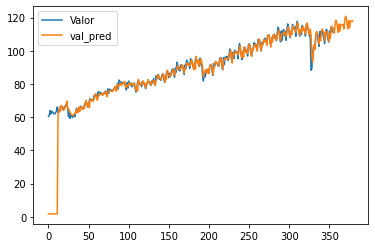

In [ ]:
df.iloc[:].plot()

Vemos la prediccion futura en una grafica

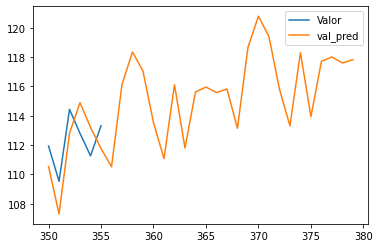

In [ ]:
df.iloc[350:].plot()

In [ ]:
df.tail(24)

,Valor,Periodo,val_pred
356,NaN,2022/09,110.526705
357,NaN,2022/10,116.144827
358,NaN,2022/11,118.350126
359,NaN,2022/12,117.040367
360,NaN,2023/01,113.530171
361,NaN,2023/02,111.082870
362,NaN,2023/03,116.123995
363,NaN,2023/04,111.806114
364,NaN,2023/05,115.622564
365,NaN,2023/06,115.957012


Podemos ver que las y_predecidas siguen la misma tendencia de las anteriores, y en este caso podemos ver que va aumentando